In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing Required Libraries  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler,LabelEncoder,MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score,confusion_matrix,classification_report,roc_auc_score,roc_curve, log_loss
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter

In [ ]:
import os
import skimage
import skimage.io
from skimage import transform
from skimage.transform import resize
from skimage.color import rgb2gray
import cv2

# Loading and Preprocessing the Image Dataset

## The function load_data():

#### Scans directories in the dataset folder.
#### Reads and resizes images to 28x28 pixels.
#### Converts images to grayscale.
#### Flattens the images into a single feature vector for easier model input.
#### Assigns labels based on folder names.

In [ ]:
def load_data(data_dir):
    dirs = [d for d in os.listdir(data_dir)
            if os.path.isdir(os.path.join(data_dir,d))]
    
    labels = []
    images = []
    
    label_map = {label: inx for inx,label in enumerate(dirs)}
    
    for d in dirs:
        label_dir = os.path.join(data_dir,d)
        
        file_name = [os.path.join(label_dir,f)
                    for f in os.listdir(label_dir) 
                    if f.endswith(".jpg")]
        
        for f in file_name:
            print(f)
            img = skimage.io.imread(f)
            img_resize = resize(img, (28,28,3))
            gray_img = rgb2gray(img_resize)
            images.append(gray_img.flatten())
            labels.append(label_map[d])
    return images, labels

In [ ]:
root_path = kagglehub.dataset_download("hearfool/vggface2")
train_data_dir = os.path.join(root_path,"train")
val_data_dir = os.path.join(root_path,"val")

In [ ]:
, labels = load_data(train_data_dir)

In [87]:
len(images)

21295

In [ ]:
images , labels = load_data(val_data_dir)

# Class Distribution Analysis


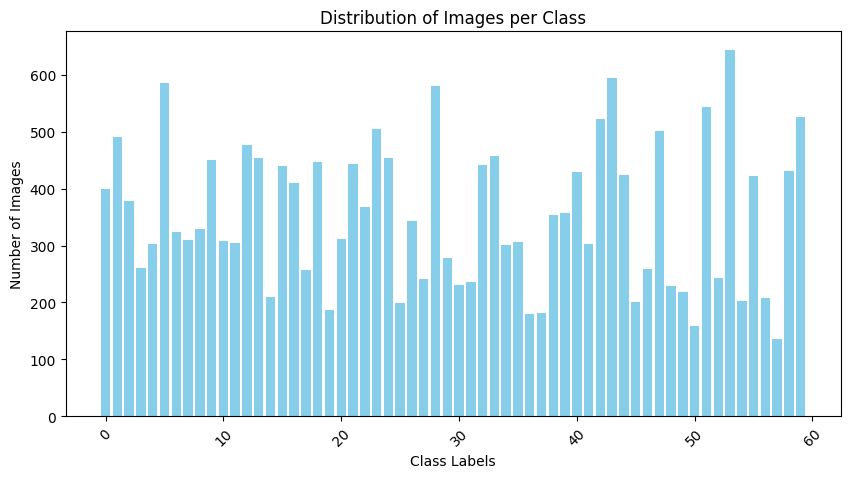

In [77]:
def plot_class_distribution(labels):
    label_counts = Counter(labels)
    
    plt.figure(figsize=(10, 5))
    plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
    plt.xlabel("Class Labels")
    plt.ylabel("Number of Images")
    plt.title("Distribution of Images per Class")
    plt.xticks(rotation=45)
    plt.show()


plot_class_distribution(labels)

# Sample Images from Dataset

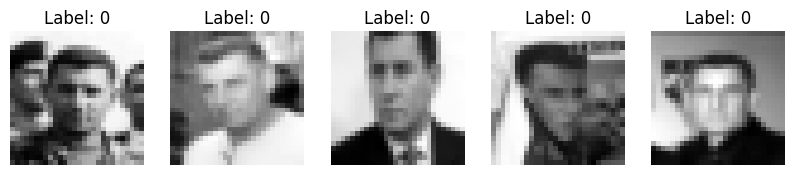

In [78]:
def plot_sample_images(images, labels, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i].reshape(28,28), cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.show()


plot_sample_images(images, labels)


In [79]:
image_means = [np.mean(img) for img in images]
image_std = [np.std(img) for img in images]


# Image Intensity Distribution

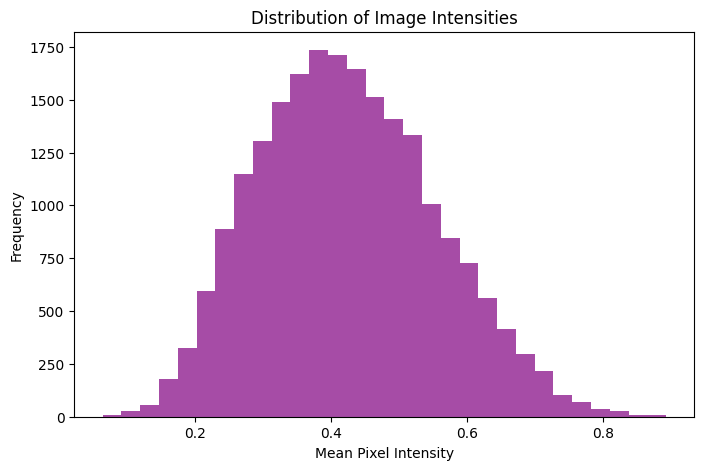

In [80]:
plt.figure(figsize=(8, 5))
plt.hist(image_means, bins=30, color='purple', alpha=0.7)
plt.xlabel("Mean Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Distribution of Image Intensities")
plt.show()

# Image Similarity Analysis using PCA


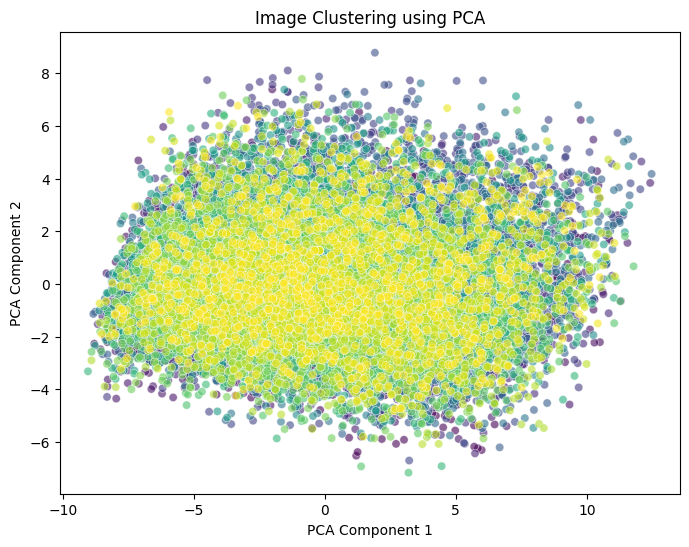

In [81]:
from sklearn.decomposition import PCA
import seaborn as sns


pca = PCA(n_components=2)
image_pca = pca.fit_transform(images)


plt.figure(figsize=(8,6))
sns.scatterplot(x=image_pca[:, 0], y=image_pca[:, 1], hue=labels, palette="viridis", alpha=0.6)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Image Clustering using PCA")
plt.legend([],[], frameon=False)  
plt.show()


# Image Similarity Analysis using t-SNE

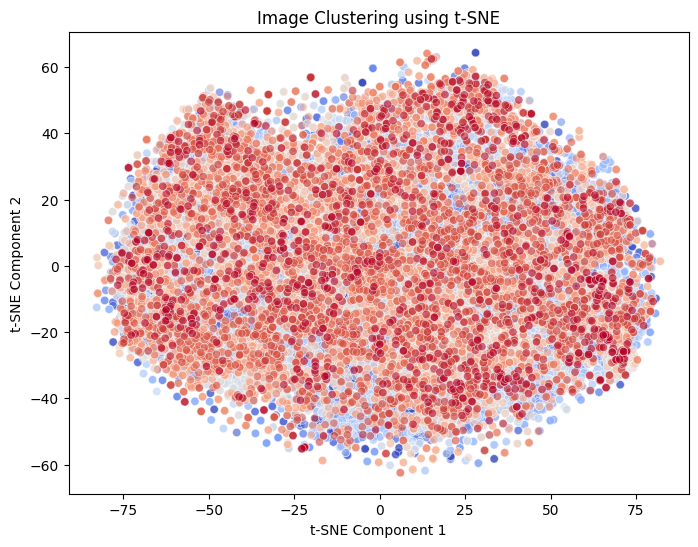

In [82]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

images_np = np.array(images)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
image_tsne = tsne.fit_transform(images_np)


plt.figure(figsize=(8,6))
sns.scatterplot(x=image_tsne[:, 0], y=image_tsne[:, 1], hue=labels, palette="coolwarm", alpha=0.6)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Image Clustering using t-SNE")
plt.legend([],[], frameon=False) 
plt.show()


# Detecting Invalid Images (Blank & Blurry Images)


In [83]:
def detect_blank_images(images, threshold=0.02):
    blank_images = [i for i, img in enumerate(images) if np.mean(img) < threshold]
    print(f"Number of blank or very dark images: {len(blank_images)}")
    return blank_images


blank_images = detect_blank_images(images)


Number of blank or very dark images: 0


# Image Size Distribution Analysis


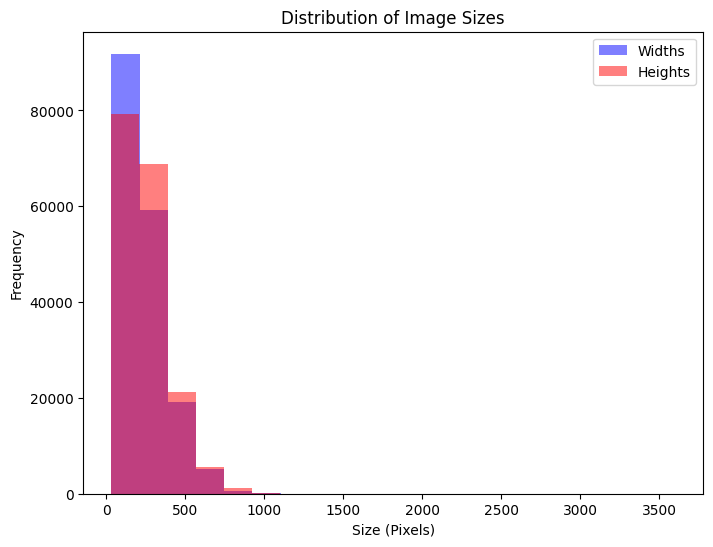

In [84]:
import os
from PIL import Image

def analyze_image_sizes(train_data_dir):
    widths, heights = [], []
    
    for subdir in os.listdir(train_data_dir):
        subdir_path = os.path.join(train_data_dir, subdir)
        if os.path.isdir(subdir_path):
            for file in os.listdir(subdir_path):
                if file.endswith(".jpg"):
                    img_path = os.path.join(subdir_path, file)
                    with Image.open(img_path) as img:
                        widths.append(img.width)
                        heights.append(img.height)
    
    plt.figure(figsize=(8,6))
    plt.hist(widths, bins=20, alpha=0.5, label="Widths", color="blue")
    plt.hist(heights, bins=20, alpha=0.5, label="Heights", color="red")
    plt.xlabel("Size (Pixels)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Image Sizes")
    plt.legend()
    plt.show()


analyze_image_sizes(train_data_dir)


# Detecting Blurry Images using Laplacian Variance


In [85]:
import cv2

def detect_blurry_images(images, threshold=100):
    blurry_images = []
    for i, img in enumerate(images):
        img_reshaped = img.reshape(28, 28)  
        variance = cv2.Laplacian(img_reshaped, cv2.CV_64F).var()
        if variance < threshold:
            blurry_images.append(i)
    print(f"Number of blurry images: {len(blurry_images)}")
    return blurry_images


blurry_images = detect_blurry_images(images)


Number of blurry images: 21295


#  Preparing Training Data

In [ ]:
target = np.array(labels)

In [ ]:
flat_images = np.array(images)

In [86]:
df = pd.DataFrame(flat_images)

df['target'] = target

x_train = df.iloc[:,:-1]

y_train = df.iloc[:,-1]

# Preparing Test Data

In [ ]:
test_target = np.array(labels)

In [ ]:
flat_test_images = np.array(images)

In [ ]:
df = pd.DataFrame(flat_test_images)

df['target'] = test_target

x_test = df.iloc[:,:-1]

y_test = df.iloc[:,-1]